## Procedures

- [Project Description](#in)
- [1: Loading the dataset](#1)
- [2: Exploratory data analysis (EDA)](#2)
- [3: Preprocessing and pipelines](#3)
- [4: Building models](#4)
- [5: Evaluating on the test set](#5)

In [4]:
# Import libraries
from hashlib import sha1

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import HTML

pd.set_option("display.max_colwidth", 200)

from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    Normalizer,
    OneHotEncoder,
    StandardScaler,
    normalize,
    scale,
)
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

import altair as alt
# Save a vega-lite spec and a PNG blob for each plot in the notebook
alt.renderers.enable("mimetype")
# Handle large data sets without embedding them in the notebook
alt.data_transformers.enable("data_server")

DataTransformerRegistry.enable('data_server')

## Project Description <a name="in"></a>

In this project, a classification model is built on a real-world dataset [the adult census dataset](https://www.kaggle.com/uciml/adult-census-income#) from Kaggle. 

This is a classification dataset and the classification task is to predict whether income exceeds 50K per year or not based on the census data. You can find more information on the dataset and features [here](http://archive.ics.uci.edu/ml/datasets/Adult).

## 1: Loading the dataset <a name="1"></a>
<hr>

The dataset `adult.csv` can be found in the data folder.

The starter code below loads the data CSV.

*Note that many popular datasets have sex as a feature where the possible values are male and female. This representation reflects how the data were collected and is not meant to imply that, for example, gender is binary.*

In [6]:
### Loading the dataset

# I am undersampling the dataset so that the labels are balanced.
adult_df_large = pd.read_csv("data/adult.csv")
g50k = adult_df_large[adult_df_large["income"] == ">50K"]
leq50k_sample = adult_df_large[adult_df_large["income"] == "<=50K"].sample(
    g50k.shape[0]
)
census_df = pd.concat([g50k, leq50k_sample])
census_df.shape

(15682, 15)

### 1.1 Data splitting 

In order to avoid violation of the golden rule, the first step before we do anything is splitting the data:

Split the data into `train_df` (80%) and `test_df` (20%). Keep the target column (`income`) in the splits so that we can use it in EDA. 


In [39]:
train_df, test_df = train_test_split(census_df, test_size=0.2, random_state=123)

## 2: Exploratory data analysis (EDA) <a name="2"></a> 
<hr>

Let's examine our `train_df`. 

In [40]:
train_df.sort_index().head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
7,74,State-gov,88638,Doctorate,16,Never-married,Prof-specialty,Other-relative,White,Female,0,3683,20,United-States,>50K
9,41,Private,70037,Some-college,10,Never-married,Craft-repair,Unmarried,White,Male,0,3004,60,?,>50K
10,45,Private,172274,Doctorate,16,Divorced,Prof-specialty,Unmarried,Black,Female,0,3004,35,United-States,>50K
11,38,Self-emp-not-inc,164526,Prof-school,15,Never-married,Prof-specialty,Not-in-family,White,Male,0,2824,45,United-States,>50K


We see some missing values represented with a "?". Probably these were the questions not answered by some people during the census.  Usually `.describe()` or `.info()` methods would give you information on missing values. But here, they won't pick "?" as missing values as they are encoded as strings instead of an actual NaN in Python. So let's replace them with `np.NaN` before we carry out EDA. If you do not do it, you'll encounter an error later on when you try to pass this data to a classifier. 

In [41]:
train_df_nan = train_df.replace("?", np.NaN)
test_df_nan = test_df.replace("?", np.NaN)

### 2.1 Numeric vs. categorical features

1. Identify numeric and categorical features and create lists for each of them. 
2. Check if there are any features which are neither numeric nor categorical in this dataset. If yes, create a separate list for those features.

In [42]:
### 2.1.1
# numeric_features = train_df.select_dtypes(include="int64").columns.to_list()
numeric_features = ['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week']

# categorical_features = train_df.select_dtypes(include="object").columns.to_list()
categorical_features = ['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'native.country']

### 2.1.2
# remainder_features = []
# There is no feature that is neither numeric nor categorical in this dataset.

### 2.2 Visualizing features

1. Use `train_df_nan.info()` method to describe information of each feature and `train_df_nan.describe()` using the `include="all"` argument to show summary statistics of each feature. 
2. Visualize the histograms of numeric features. 
3. Check which features seem relevant for the given prediction task

We can also use `pandas_profiling` for more elaborate visualization and EDA. 

In [11]:
### describe information of each feature
train_df_nan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12545 entries, 17825 to 10168
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             12545 non-null  int64 
 1   workclass       11971 non-null  object
 2   fnlwgt          12545 non-null  int64 
 3   education       12545 non-null  object
 4   education.num   12545 non-null  int64 
 5   marital.status  12545 non-null  object
 6   occupation      11970 non-null  object
 7   relationship    12545 non-null  object
 8   race            12545 non-null  object
 9   sex             12545 non-null  object
 10  capital.gain    12545 non-null  int64 
 11  capital.loss    12545 non-null  int64 
 12  hours.per.week  12545 non-null  int64 
 13  native.country  12333 non-null  object
 14  income          12545 non-null  object
dtypes: int64(6), object(9)
memory usage: 1.5+ MB


In [12]:
### show summary statistics of each feature
train_df_nan.describe(include="all")

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
count,12545.000000,11971,1.254500e+04,12545,12545.000000,12545,11970,12545,12545,12545,12545.000000,12545.000000,12545.000000,12333,12545
unique,NaN,8,NaN,16,NaN,7,14,6,5,2,NaN,NaN,NaN,40,2
top,NaN,Private,NaN,HS-grad,NaN,Married-civ-spouse,Exec-managerial,Husband,White,Male,NaN,NaN,NaN,United-States,>50K
freq,NaN,8437,NaN,3554,NaN,7484,2132,6602,10926,9116,NaN,NaN,NaN,11333,6281
mean,40.493105,NaN,1.881604e+05,NaN,10.593942,NaN,NaN,NaN,NaN,NaN,2088.514149,127.274851,42.068075,NaN,NaN
std,12.952965,NaN,1.041577e+05,NaN,2.612085,NaN,NaN,NaN,NaN,NaN,10501.221279,485.280796,12.182230,NaN,NaN
min,17.000000,NaN,1.487800e+04,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,1.000000,NaN,NaN
25%,31.000000,NaN,1.176740e+05,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
50%,40.000000,NaN,1.769860e+05,NaN,10.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
75%,49.000000,NaN,2.340570e+05,NaN,13.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,49.000000,NaN,NaN


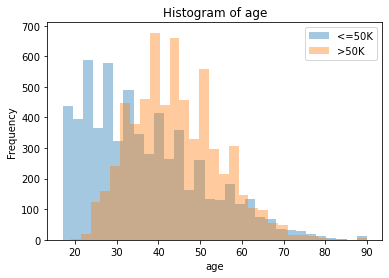

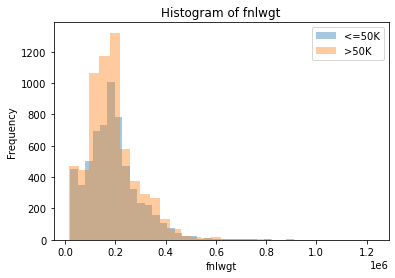

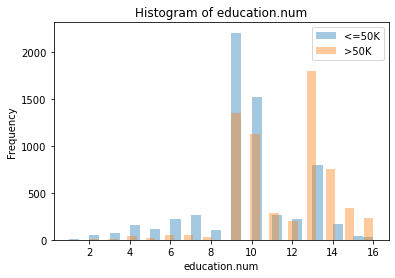

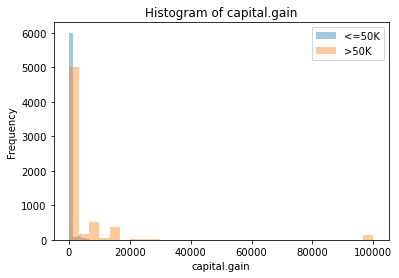

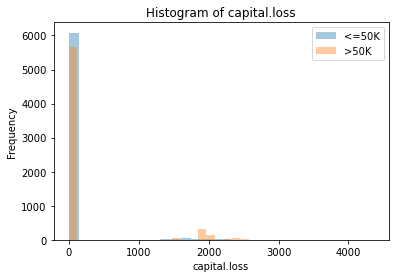

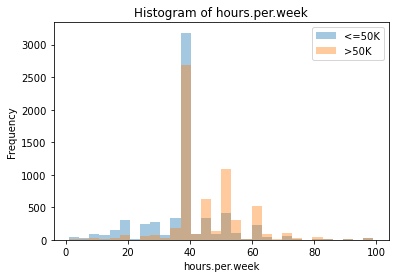

In [7]:
### Visualize the histograms of numeric features using pandas plotting
for feat in numeric_features:
    ax = train_df_nan.groupby("income")[feat].plot.hist(bins=30, alpha=0.4, legend=True)
    plt.xlabel(feat)
    plt.title("Histogram of " + feat)
    plt.show()


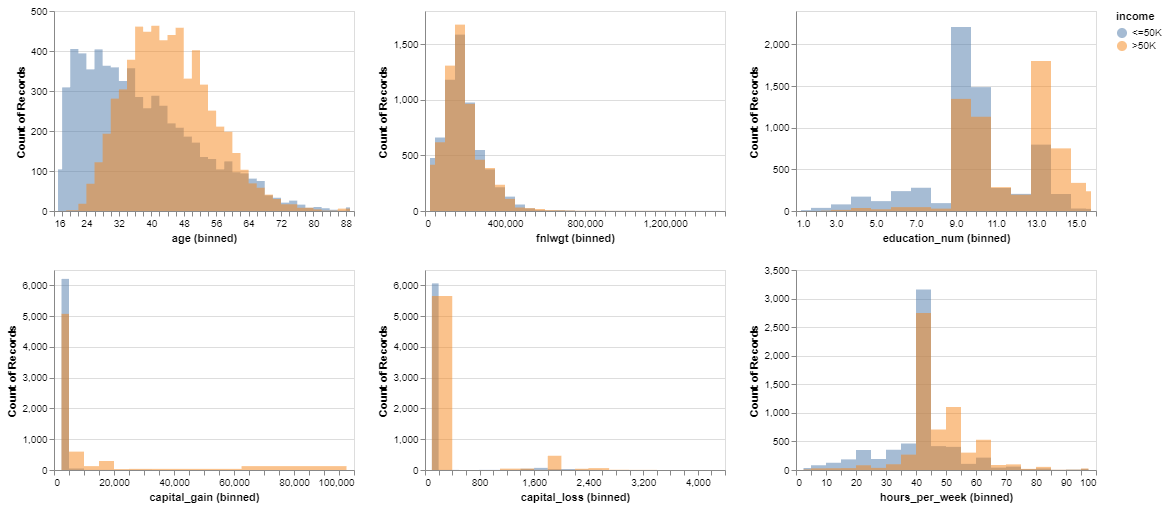

In [27]:
# Or Visualize using `altair`
# train_df_nan.columns = ['age', 'workclass', 'fnlwgt', 'education', 'education_num',
#        'marital_status', 'occupation', 'relationship', 'race', 'sex',
#        'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
#        'income']
# numeric_features = train_df_nan.select_dtypes(include="number").columns.to_list()
# (
#     alt.Chart(train_df_nan)
#         .mark_area(opacity=0.5, interpolate='step')
#         .encode(
#             x=alt.X(alt.repeat("repeat"), type="quantitative", bin=alt.Bin(maxbins=40), scale=alt.Scale(zero=False)),
#             y=alt.Y("count()", type="quantitative", scale=alt.Scale(zero=False), stack=None),
#             color='income')
#         .properties(width=300, height=200)
#         .repeat(repeat=numeric_features, columns=3)
# )

The features `age`, `education.num`, `capital.gain` and `hours.per.week` seem to be relevant to our target `income`.

### 2.3 Separating feature vectors and targets  

1. Create `X_train`, `y_train`, `X_test`, `y_test` from `train_df_nan` and `test_df_nan`. 

In [43]:
X_train, y_train = train_df_nan.drop(columns=["income"]), train_df_nan["income"]
X_test, y_test = test_df_nan.drop(columns=["income"]), test_df_nan["income"]

## 3: Preprocessing <a name="3"></a>
<hr>

- Before we train [`sklearn`'s `SVC`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) model on `X_train` and `y_train`, the categorical features in `X_train` should be transformed to numeric ones such that they can be used to calculate distance between feature vectors.

In this step, we'll be wrangling the dataset so that it's suitable to be used with `scikit-learn` classifiers. 

### 3.1 Identifying transformations that need to be applied

Identify the columns on which transformations need to be applied and determine what transformation we would apply in what order, as shown in the table.

### Feature Transformation Table
| Feature | Transformation |
| --- | ----------- |
| age | imputation, scaling |
| workclass | imputation, One-hot encoding |
| fnlwgt | imputation, scaling |
| education | imputation, One-hot encoding |
| education.num | imputation, scaling |
| marital.status | imputation, One-hot encoding |
| occupation | imputation, One-hot encoding |
| relationship | imputation, One-hot encoding |
| race | imputation, One-hot encoding |
| sex | imputation, One-hot encoding |
| capital.gain | imputation, scaling |
| capital.loss | imputation, scaling |
| hours.per.week | imputation, scaling |
| native.country | imputation, One-hot encoding |

### The feature(s) that don't need to be transformed

Actually we don't need to apply transformations on the column `education` since it plays the same role as the column `education.num` that could be considered as the transformed feature of `education`.

### 3.2 Imputing missing values **without** `sklearn.pipeline.Pipeline`

In this step, we'll be imputing missing values **without using `scikit-learn` pipelines**. The goal here is two-fold. First, to understand what happens under the hood when you use `scikit-learn` `Pipelines`, and second, to convince yourself why it's a good idea to use pipelines.  

1. For numeric features, use [`scikit-learn`'s `SimpleImputer`](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) to impute `NaN` values with `strategy="median"`. Remember to apply the transformations on both the train and test splits.  
2. For categorical features, use [`scikit-learn`'s `SimpleImputer`](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) to impute `NaN` values by a constant string "missing". Remember to apply the transformations on both the train and test splits.
3. Show train split of categorical features in a dataframe after transforming the missing values. 

In [44]:
### 3.2.1
numeric_imputer = SimpleImputer(strategy="median")
numeric_imputer.fit(X_train[numeric_features])
X_train_numeric_imp = numeric_imputer.transform(X_train[numeric_features])
X_test_numeric_imp = numeric_imputer.transform(X_test[numeric_features])

In [45]:
### 3.2.2
categorical_imputer = SimpleImputer(strategy="constant", fill_value="missing")
categorical_imputer.fit(X_train[categorical_features])
X_train_categorical_imp = categorical_imputer.transform(X_train[categorical_features])
X_test_categorical_imp = categorical_imputer.transform(X_test[categorical_features])

In [46]:
### 3.2.3
pd.DataFrame(X_train_categorical_imp, columns=categorical_features, index=X_train.index)

,workclass,education,marital.status,occupation,relationship,race,sex,native.country
17825,Private,HS-grad,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,United-States
2444,Federal-gov,Bachelors,Married-civ-spouse,Sales,Husband,White,Male,United-States
2039,Local-gov,Bachelors,Married-civ-spouse,Protective-serv,Husband,White,Male,United-States
7529,Self-emp-inc,Masters,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States
22427,Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,Male,United-States
...,...,...,...,...,...,...,...,...
18851,Private,Bachelors,Married-civ-spouse,Transport-moving,Husband,White,Male,United-States
24544,State-gov,Bachelors,Divorced,Exec-managerial,Not-in-family,Asian-Pac-Islander,Female,United-States
2100,Private,HS-grad,Married-civ-spouse,Sales,Husband,White,Male,United-States
17084,Private,HS-grad,Divorced,Other-service,Unmarried,White,Female,United-States


- It shows two missing values in the last row

### 3.3 One-hot encoding **without** `sklearn.pipeline.Pipeline`

1. Apply one-hot encoding to the categorical features of imputed `X_train` and `X_test` from 3.2 using [`scikit-learn`'s `OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) and show the new columns created using the `categories_` attribute of the `OneHotEncoder` object.
2. Create preprocessed train and test splits, `X_train_pp` and `X_test_pp`, by horizontally stacking transformed numeric columns from 3.2 and transformed categorical columns with imputation and OHE applied. 
3. Display the shape of `X_train_pp` and `X_test_pp`

In [47]:
ohe = OneHotEncoder(handle_unknown="ignore", sparse=False, dtype="int")
X_train_categorical_imp_ohe = ohe.fit_transform(X_train_categorical_imp)
X_test_categorical_imp_ohe = ohe.transform(X_test_categorical_imp)
ohe.categories_

[array(['Federal-gov', 'Local-gov', 'Never-worked', 'Private',
        'Self-emp-inc', 'Self-emp-not-inc', 'State-gov', 'Without-pay',
        'missing'], dtype=object),
 array(['10th', '11th', '12th', '1st-4th', '5th-6th', '7th-8th', '9th',
        'Assoc-acdm', 'Assoc-voc', 'Bachelors', 'Doctorate', 'HS-grad',
        'Masters', 'Preschool', 'Prof-school', 'Some-college'],
       dtype=object),
 array(['Divorced', 'Married-AF-spouse', 'Married-civ-spouse',
        'Married-spouse-absent', 'Never-married', 'Separated', 'Widowed'],
       dtype=object),
 array(['Adm-clerical', 'Armed-Forces', 'Craft-repair', 'Exec-managerial',
        'Farming-fishing', 'Handlers-cleaners', 'Machine-op-inspct',
        'Other-service', 'Priv-house-serv', 'Prof-specialty',
        'Protective-serv', 'Sales', 'Tech-support', 'Transport-moving',
        'missing'], dtype=object),
 array(['Husband', 'Not-in-family', 'Other-relative', 'Own-child',
        'Unmarried', 'Wife'], dtype=object),
 array(['Amer-I

In [48]:
X_train_pp = np.hstack((X_train_numeric_imp, X_train_categorical_imp_ohe))
X_test_pp = np.hstack((X_test_numeric_imp, X_test_categorical_imp_ohe))

In [49]:
print(f"The shape of X_train_pp is {X_train_pp.shape}")
print(f"The shape of X_test_pp is {X_test_pp.shape}")

The shape of X_train_pp is (12545, 107)
The shape of X_test_pp is (3137, 107)


- Note: We cannot carry out cross validation using `cross_validate` on the preprocessed `X_train_pp` and `y_train`, for example, using the [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html?highlight=kneighborsclassifier#sklearn.neighbors.KNeighborsClassifier) as below, since we are violating the golden rule. All the rows in the preprocessed `X_train_pp` were transformed by the numeric imputer with median strategy. When we call `cross_validate` on the `X_train_pp`, the rows from validation split in each fold have been used to calculate the median, influencing the training step of knn model.

In [18]:
knn = KNeighborsClassifier()
scores = cross_validate(knn, X_train_pp, y_train, return_train_score=True)
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.283032,0.164966,0.609406,0.741530
1,0.265625,0.171877,0.592268,0.745018
2,0.273998,0.189000,0.591869,0.743025
3,0.265625,0.171876,0.599841,0.743922
4,0.271000,0.167001,0.598246,0.741331


### 3.4 Using `sklearn.pipeline.Pipeline`

As noted in 3.2 and 3.3, when we want to apply a series of transformations, the code becomes unwieldy quite quickly. We can do this much more elegantly using [`scikit-learn` pipelines](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html).   

Let's carry out preprocessing using pipelines now. Note that you can define pipelines in two ways: by using [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) and providing named steps or by using [`make_pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html#sklearn.pipeline.make_pipeline) which allows for simplified pipeline construction. In the latter case, the names of the steps will be set to the lowercase of their types automatically. You may use the method of your choice.  


1. Define a `Pipeline` for numerical features with two steps: 
    - [`SimpleImputer()`](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) with `strategy = "median"` 
    - [`StandardScaler()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)
2. Define a `Pipeline` for categorical features with two steps: 
    - [`SimpleImputer()`](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) with `strategy = "constant"`
    - [`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) with `handle_unknown="ignore"`

3. Define a [`ColumnTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html) called `preprocessor` for the numerical, categorical, and remainder features.
4. Fit the `preprocessor` on `X_train` and `y_train`.
5. Examine the new features created by the `OneHotEncoder`.

In [50]:
### Pipeline
numeric_transformer = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler()
)

categorical_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OneHotEncoder(handle_unknown="ignore")
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)
preprocessor.fit(X_train, y_train)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['age', 'fnlwgt', 'education.num',
                                  'capital.gain', 'capital.loss',
                                  'hours.per.week']),
                                ('cat',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['workcl

In [20]:
preprocessor.named_transformers_["cat"].named_steps["onehotencoder"].get_feature_names(categorical_features)

# By eyeballing it, there are 5 new features created for the categorical feature `marital.status`

array(['workclass_Federal-gov', 'workclass_Local-gov',
       'workclass_Never-worked', 'workclass_Private',
       'workclass_Self-emp-inc', 'workclass_Self-emp-not-inc',
       'workclass_State-gov', 'workclass_Without-pay',
       'workclass_missing', 'education_10th', 'education_11th',
       'education_12th', 'education_1st-4th', 'education_5th-6th',
       'education_7th-8th', 'education_9th', 'education_Assoc-acdm',
       'education_Assoc-voc', 'education_Bachelors',
       'education_Doctorate', 'education_HS-grad', 'education_Masters',
       'education_Preschool', 'education_Prof-school',
       'education_Some-college', 'marital.status_Divorced',
       'marital.status_Married-AF-spouse',
       'marital.status_Married-civ-spouse',
       'marital.status_Married-spouse-absent',
       'marital.status_Never-married', 'marital.status_Separated',
       'marital.status_Widowed', 'occupation_Adm-clerical',
       'occupation_Armed-Forces', 'occupation_Craft-repair',
       'occ

## 4: Building models <a name="4"></a>
<hr>

Now that we have preprocessed features, we are ready to build models. 

In [21]:
# Lets create an empty dictionary to store all the results
results_dict = {}

In [22]:
# Use this support function to keep your results organized
def store_cross_val_results(model_name, scores, results_dict):
    """
    Stores mean scores from cross_validate in results_dict for
    the given model model_name.

    Parameters
    ----------
    model_name :
        scikit-learn classification model
    scores : dict
        object return by `cross_validate`
    results_dict: dict
        dictionary to store results

    Returns
    ----------
        None

    """
    results_dict[model_name] = {
        "mean_train_accuracy": "{:0.4f}".format(np.mean(scores["train_score"])),
        "mean_validation_accuracy": "{:0.4f}".format(np.mean(scores["test_score"])),
        "mean_fit_time (s)": "{:0.4f}".format(np.mean(scores["fit_time"])),
        "mean_score_time (s)": "{:0.4f}".format(np.mean(scores["score_time"])),
        "std_train_score": "{:0.4f}".format(scores["train_score"].std()),
        "std_test_score": "{:0.4f}".format(scores["test_score"].std()),
    }


### 4.1 Building a baseline model 

1. Define a pipeline with two steps: preprocessor from 3.4 and `scikit-learn`'s `DummyClassifier` with `strategy="prior"` as your classifier.  
2. Carry out 5-fold cross validation with the pipeline. Store the results in `results_dict` above.

In [23]:
pipe = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("dc", DummyClassifier(strategy="prior"))
    ]
)

scores = cross_validate(pipe, X_train, y_train, cv=5, return_train_score=True)
store_cross_val_results("dummy", scores, results_dict)
pd.DataFrame(results_dict).T  # .T transpose the index and columns of the df

,mean_fit_time (s),mean_score_time (s),mean_train_accuracy,mean_validation_accuracy,std_test_score,std_train_score
dummy,0.0412,0.0137,0.5007,0.5007,0.0002,0.0000


### 4.2 Trying different classifiers

1. For each of the models in the starter code below: 
    - Define a pipeline with two steps: preprocessor from 3.4 and the model as your classifier.  
    - Carry out 5-fold cross validation with the pipeline using `cross_validate`.
    - Store the results in `results_dict`.
2. Display all the results so far as a dataframe. 
3. Compare the train and validation accuracies and `fit` and `score` times in each case.

In [24]:
### Build models

models = {
    "decision tree": DecisionTreeClassifier(),
    "kNN": KNeighborsClassifier(),
    "RBF SVM": SVC(),
}

In [25]:
for name, model in models.items():
    pipe = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            (name, model)
        ]
    )
    scores = cross_validate(pipe, X_train, y_train, cv=5, return_train_score=True)
    store_cross_val_results(name, scores, results_dict)

In [26]:
pd.DataFrame(results_dict).T

,mean_train_accuracy,mean_validation_accuracy,mean_fit_time (s),mean_score_time (s),std_train_score,std_test_score
dummy,0.5007,0.5007,0.0412,0.0137,0.0000,0.0002
decision tree,1.0000,0.7681,0.3627,0.0114,0.0000,0.0060
kNN,0.8541,0.7951,0.0512,0.9809,0.0017,0.0064
RBF SVM,0.8463,0.8282,3.5244,0.5950,0.0027,0.0098


### Report

Compared to the baseline `DummyClassifier` model from 4.1, all the training and validation accuracies of the other three models are quite higher than those dummy model has. The `RBF SVM` model has the best validation accuracy. It is also the best model here among the four models, with a high training accuracy (quite close to that of `kNN`) and the lowest gap between training and validation accuracies. The `DecesionTree` model is overfitting with the highest training accuracy but a large gap between the training accuracy and valication accuracy.

Regarding to `fit` and `score` times, the `DummyClassifier` model is the fastest model among the four models. The `DecisionTree` model takes more time in fitting than the `DummyClassifier` model for learning the features, but score time is almost the same. The `kNN` model has roughly the same `fit` time as the `DummyClassifier` model since it doesn't learn in the fitting phase, whereas it spends the most time in predicting. The `RBF SVM` model has the highest `fit` time due to the calculations of distances in fitting step. It also takes some time in prediction, but lower than the `kNN` model.

### 4.3 Exploring importance of scaling

Examine whether scaling helps in case of KNN and RBF SVM:

1. Create a column transformer without the `StandardScaler` step for `numeric_features`. 
2. Repeat the steps in 4.2 with this new column transformer. 
3. Compare the results with scaled numeric features with unscaled numeric features.

In [27]:
results_dict_no_scaler = {}

numeric_transformer_no_scaler = make_pipeline(
    SimpleImputer(strategy="median")
)
categorical_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OneHotEncoder(handle_unknown="ignore")
)

preprocessor_no_scaler = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_no_scaler, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

models = {
    "dummy": DummyClassifier(strategy="prior"),
    "decision tree": DecisionTreeClassifier(),
    "kNN": KNeighborsClassifier(),
    "RBF SVM": SVC(),
}

for name, model in models.items():
    pipe = Pipeline(
        steps=[
            ("preprocessor", preprocessor_no_scaler),
            (name, model)
        ]
    )
    scores = cross_validate(pipe, X_train, y_train, cv=5, return_train_score=True)
    store_cross_val_results(name, scores, results_dict_no_scaler)

pd.DataFrame(results_dict_no_scaler).T

,mean_train_accuracy,mean_validation_accuracy,mean_fit_time (s),mean_score_time (s),std_train_score,std_test_score
dummy,0.5007,0.5007,0.0376,0.0159,0.0000,0.0002
decision tree,1.0000,0.7721,0.3405,0.0099,0.0000,0.0054
kNN,0.7430,0.5984,0.0446,0.9665,0.0014,0.0064
RBF SVM,0.5786,0.5778,6.0951,1.2283,0.0015,0.0054


### Report

The Scaling is not necessary for decision tree. As we can see from the results in `4.3` and `4.2`, the training and validation accuracies have almost the same values. That consistency is attributed to the fact that in decision trees, we ask questions only on one feature and one split threshold at a time, without considering all features at once. Scaling is not necessary for decision trees learning split threshold values.

### 4.4 Hyperparameter optimization

In practice, we'll carry out hyperparameter optimization for all different hyperparameters for the most promising classifiers.

For now, we just carry out hyperparameter optimization for the hyperparameter `C` of our best performing SVC RBF classifier. For each `C` value in the `param_grid` in the starter code below: 
   - Create a pipeline object with two steps: preprocessor from 3.4 and SVC classifier with the value of `C`.
   - Carry out cross-validation using `cross_validate` and store results in the `results_dict` using the function `store_cross_val_results`. You may pass the `model_name` as `SVC` + the current `C` value. 

In [28]:
param_grid = {"C": np.logspace(-3, 2, 6)}

In [29]:
numeric_transformer = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler()
)

categorical_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OneHotEncoder(handle_unknown="ignore")
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

for c_value in param_grid["C"]:
    pipe = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("SVC", SVC(C=c_value))
        ]
    )
    scores = cross_validate(pipe, X_train, y_train, cv=5, return_train_score=True)
    store_cross_val_results("SVC_" + str(c_value), scores, results_dict)

In [30]:
results_df = pd.DataFrame(results_dict).T
results_df

,mean_train_accuracy,mean_validation_accuracy,mean_fit_time (s),mean_score_time (s),std_train_score,std_test_score
dummy,0.5007,0.5007,0.0412,0.0137,0.0000,0.0002
decision tree,1.0000,0.7681,0.3627,0.0114,0.0000,0.0060
kNN,0.8541,0.7951,0.0512,0.9809,0.0017,0.0064
RBF SVM,0.8463,0.8282,3.5244,0.5950,0.0027,0.0098
SVC_0.001,0.6931,0.6930,6.0370,1.2601,0.0053,0.0020
SVC_0.01,0.7962,0.7954,4.6543,0.8977,0.0022,0.0077
SVC_0.1,0.8211,0.8163,3.3090,0.6568,0.0030,0.0060
SVC_1.0,0.8463,0.8282,3.0673,0.5481,0.0027,0.0098
SVC_10.0,0.8885,0.8198,3.9874,0.5505,0.0014,0.0080
SVC_100.0,0.9305,0.7950,8.1743,0.5282,0.0016,0.0081


### Report

It seems that when the hyperparameter `C=1.0`, `SVC` performs the best among the six values of C because when `C=1.0`, the `SVC` model has the best validation accuracy with a quite small gap between the training and validation accuracies. It is the same as the default value for `C` used by `scikit-learn`.

### 4.5 Hyperparameter optimization of multiple parameters

As we saw in class `SVC` has two important hyperparameters: `C` and `gamma` which may interact with each other and we need to optimize them both simultaneously.  

Let's carry out hyperparameter optimization of `C` and `gamma` simultaneously for the param grid. 


In [31]:
### TO ADD

## 5: Evaluating on the test set <a name="5"></a>
<hr>

Now that we have a best performing model, it's time to assess our model on the set aside test set.

Examine whether the results we obtained using cross-validation on the train set are consistent with the results on the test set. 

### 5.1 Scoring on the unseen test set 

1. Report the results on `X_test` for all classifiers. Pick the best hyperparameter from 4.4 for the SVC RBF classifier. 
2. Compare and discuss the train, validation, and test results of all classifiers. 

In [32]:
test_results = {}

models = {
    "dummy": DummyClassifier(strategy="prior"),
    "decision tree": DecisionTreeClassifier(),
    "kNN": KNeighborsClassifier(),
    "SVC_0.001": SVC(C=1.e-03),
    "SVC_0.01": SVC(C=1.e-02),
    "SVC_0.1": SVC(C=1.e-01),
    "SVC_1.0": SVC(C=1.e-00),
    "SVC_10.0": SVC(C=1.e-01),
    "SVC_100.0": SVC(C=1.e-02)
}

numeric_transformer = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler()
)

categorical_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OneHotEncoder(handle_unknown="ignore")
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

for name, model in models.items():
    pipe = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            (name, model)
        ]
    )
    pipe.fit(X_train, y_train)
    scores = pipe.score(X_test, y_test)
    test_results[name] = {"test_score": scores}

In [33]:
pd.merge(results_df.reset_index(),
         pd.DataFrame(test_results).T.reset_index(),
         how="inner",
         on="index")

,index,mean_train_accuracy,mean_validation_accuracy,mean_fit_time (s),mean_score_time (s),std_train_score,std_test_score,test_score
0,dummy,0.5007,0.5007,0.0412,0.0137,0.0000,0.0002,0.497290
1,decision tree,1.0000,0.7681,0.3627,0.0114,0.0000,0.0060,0.766656
2,kNN,0.8541,0.7951,0.0512,0.9809,0.0017,0.0064,0.794390
3,SVC_0.001,0.6931,0.6930,6.0370,1.2601,0.0053,0.0020,0.774625
4,SVC_0.01,0.7962,0.7954,4.6543,0.8977,0.0022,0.0077,0.795983
5,SVC_0.1,0.8211,0.8163,3.3090,0.6568,0.0030,0.0060,0.814791
6,SVC_1.0,0.8463,0.8282,3.0673,0.5481,0.0027,0.0098,0.821804
7,SVC_10.0,0.8885,0.8198,3.9874,0.5505,0.0014,0.0080,0.814791
8,SVC_100.0,0.9305,0.7950,8.1743,0.5282,0.0016,0.0081,0.795983


### Report

Compared to the baseline `DummyClassifier` model, the training, validation and test accuracies of all the other models are much higher than those dummy model has. The test scores of the models `DecisionTree`, `SVC_0.01`, `SVC_0.1`, `SVC_1.0`, `SVC_10.0` and `SVC_100.0` are consistent with their validation scores. The models `DummyClassifier`, `kNN` and `SVC_0.001` are underfitting (because they have low training and validation accuracies with small gap, and `kNN` and `SVC_0.001` models have much higher test scores than their validation scores). The model `DecisionTree` is overfitting with the highest training accuracy but a large gap between the training accuracy and valication accuracy.

The `SVC_1.0` model (hyperparameter `C=1.0`) performs the best among all the models, with the best validation and test accuracies and a quite small gap between training and validation accuracies.

Regarding to `fit` and `score` times, the `DummyClassifier` model is the fastest model among all the models. The `DecisionTree` model takes more time in fitting than the `DummyClassifier` model for learning the features, but their score times are almost the same. The `kNN` model has roughly the same `fit` time as the `DummyClassifier` model since it doesn't learn in the fitting phase, whereas it spends about 30X time in predicting. The `SVC` models have the much higher `fit` times than the other three models due to the calculations of distances in fitting step. It also takes some time in prediction, but lower than the `kNN` model. As the hyperparameter `C` increases, `SVC` model gets more complex, but the score time is decreasing. For the smallest and the largest values of `C`, the model takes the most `fit` times, and the model with `C=1.0` has the smallest `fit` time.